**Data mining Project - University of Pisa, acedemic year 2023/24**

**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Adaboost Classifier

AdaBoost is a bosting algorithm.

Boosting is a general method for improving the accuracy of any given learning algorith
Boosting refers to a general and provably effective method of producing a very accurate prediction rule by combining rough and moderately inaccurate rules of thumb in a manner similar to
that suggested above. 

AdaBoost algorithm takes as input a training set belongs to some domain and label in some label set. 
The algorithm originally presented works for two calss classification, but it can be extended to the multiclass case. 
AdaBoost calls a given weak or base learning algorithm repeatedly in a series of rounds. One of the main ideas of the algorithm is to maintain a distribution or set of weights over the training set.
Initially, all weights are set equally, but on each round, the weights of incorrectly classified examples are increased so that the weak learner is forced to focus on the hard examples in the training set.
The weak learner’s job is to find a weak hypothesis h appropriate for the distribution.

We import the libraries and define constants and settings of the notebook:

In [1]:
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz
from time import time
from classification_utils import *

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
RANDOM_STATE = 42
RESULTS_DIR = '../data/classification_results'
clf_name = 'AdaBoostClassifier'

We load the data:

In [2]:
# load the data
incidents_train_df = pd.read_csv('../data/clf_indicators_train.csv', index_col=0)
incidents_test_df = pd.read_csv('../data/clf_indicators_test.csv', index_col=0)
true_labels_train_df = pd.read_csv('../data/clf_y_train.csv', index_col=0)
true_labels_train = true_labels_train_df.values.ravel()
true_labels_test_df = pd.read_csv('../data/clf_y_test.csv', index_col=0)
true_labels_test = true_labels_test_df.values.ravel()

# load the names of the features to use for the classification task
features_for_clf = json.loads(open('../data/clf_indicators_names_rule_based.json').read())

# project on the features to use
indicators_train_df = incidents_train_df[features_for_clf]
indicators_test_df = incidents_test_df[features_for_clf]

We display the features names we will use:

In [3]:
print(features_for_clf)
print(f'Number of features: {len(features_for_clf)}')

['location_imp', 'x', 'y', 'age_range', 'avg_age', 'n_child_prop', 'n_teen_prop', 'n_males_prop', 'n_participants', 'day', 'day_of_week', 'month', 'year', 'days_from_first_incident', 'poverty_perc', 'democrat', 'gun_law_rank', 'aggression', 'accidental', 'defensive', 'suicide', 'road', 'house', 'school', 'business', 'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction']
Number of features: 31


We define a list of the categorical features:

In [4]:
categorical_features = [
    'day', 'day_of_week', 'month', 'year',
    'democrat', 'gun_law_rank',
    'aggression', 'accidental', 'defensive', 'suicide',
    'road', 'house', 'school', 'business',
    'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction'
]

## Grid search

'SAMME.R' real boosting algorithm. estimator must support calculation of class probabilities. 
'SAMME' then use the SAMME discrete boosting algorithm. 

The SAMME.R algorithm typically converges faster than SAMME, achieving a lower test error with fewer boosting iterations.

Both algorithms were presented in ''Multi-class AdaBoost' by Ji Zhu, Saharon Rosset, Hui Zou, Trevor Hastie.

In [5]:
param_grid = {
    'estimator': [None, 
        DecisionTreeClassifier(criterion='gini', 
        splitter='best', max_depth=None, min_samples_split=0.01, class_weight='balanced')
    ], # None=defualt: DecisionTreeClassifier with max_depth=1
    'n_estimators': [200],# 500, 1000],
    'learning_rate': [1, 0.9, 0.8],
    'algorithm': ['SAMME', 'SAMME.R'],
    'random_state': [RANDOM_STATE]
}

gs = GridSearchCV(
    AdaBoostClassifier(),
    param_grid=param_grid,
    n_jobs=-1,
    scoring=make_scorer(f1_score),
    verbose=10,
    cv=5, # uses a stratified 5-fold cv to validate the models
    refit=False
)
gs.fit(indicators_train_df, true_labels_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'estimator': [None,
                                       DecisionTreeClassifier(class_weight='balanced',
                                                              min_samples_split=0.01)],
                         'learning_rate': [1, 0.9, 0.8], 'n_estimators': [200],
                         'random_state': [42]},
             refit=False, scoring=make_scorer(f1_score), verbose=10)

In [6]:
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_estimator,param_learning_rate,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,42.433874,5.151199,1.083144,0.073262,SAMME,None,1,200,42,"{'algorithm': 'SAMME', 'estimator': None, 'learning_rate': 1, 'n_estimators': 200, 'random_state': 42}",0.467283,0.467996,0.470602,0.476028,0.465334,0.469449,0.003697,10
1,43.797345,4.984943,1.180121,0.118240,SAMME,None,0.9,200,42,"{'algorithm': 'SAMME', 'estimator': None, 'learning_rate': 0.9, 'n_estimators': 200, 'random_state': 42}",0.456181,0.461086,0.449846,0.456377,0.464073,0.457513,0.004851,11
2,46.242616,1.827966,1.298565,0.233575,SAMME,None,0.8,200,42,"{'algorithm': 'SAMME', 'estimator': None, 'learning_rate': 0.8, 'n_estimators': 200, 'random_state': 42}",0.446187,0.464340,0.455946,0.448260,0.446124,0.452171,0.007071,12
3,871.159171,23.700093,3.187253,0.125307,SAMME,"DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01)",1,200,42,"{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01), 'learning_rate': 1, 'n_estimators': 200, 'random_state': 42}",0.569636,0.574892,0.567052,0.576238,0.573782,0.572320,0.003437,3
4,911.679695,39.505069,3.177363,0.185431,SAMME,"DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01)",0.9,200,42,"{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01), 'learning_rate': 0.9, 'n_estimators': 200, 'random_state': 42}",0.572433,0.580098,0.570962,0.580952,0.578164,0.576522,0.004068,2


<Axes: xlabel='param_learning_rate', ylabel='param_algorithm-param_n_estimators'>

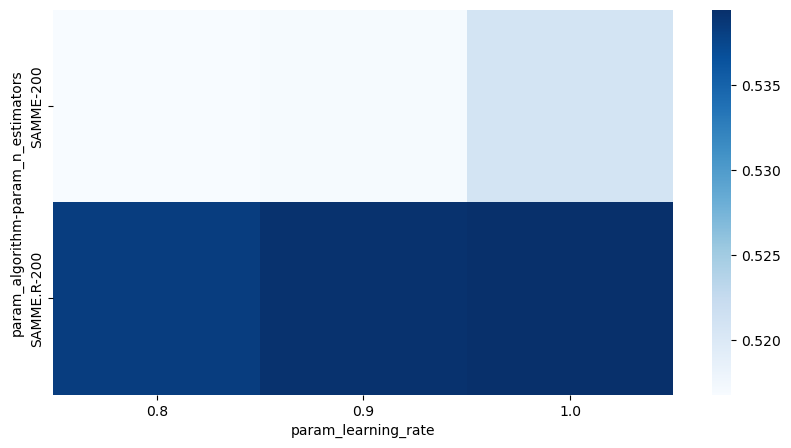

In [7]:
fig, axs = plt.subplots(1, figsize=(10, 5))
pvt = pd.pivot_table(
    cv_results_df,
    values='mean_test_score',
    index=['param_algorithm', 'param_n_estimators'],
    columns=['param_learning_rate']
)
sns.heatmap(pvt, cmap='Blues', ax=axs)

In [8]:
params = [col for col in cv_results_df.columns if 'param_' in col and 'random' not in col]
cv_results_df.sort_values(
    by='mean_test_score',
    ascending=False)[params+['std_test_score', 'mean_test_score']].head(20).style.background_gradient(subset=['std_test_score', 'mean_test_score'], cmap='Blues')

,param_algorithm,param_estimator,param_learning_rate,param_n_estimators,std_test_score,mean_test_score
5,SAMME,"DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01)",0.800000,200,0.003758,0.581472
4,SAMME,"DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01)",0.900000,200,0.004068,0.576522
3,SAMME,"DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01)",1,200,0.003437,0.572320
10,SAMME.R,"DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01)",0.900000,200,0.005102,0.554640
11,SAMME.R,"DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01)",0.800000,200,0.005075,0.553467
9,SAMME.R,"DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01)",1,200,0.002642,0.550546
6,SAMME.R,None,1,200,0.000869,0.528286
7,SAMME.R,None,0.900000,200,0.002392,0.523796
8,SAMME.R,None,0.800000,200,0.001279,0.522948
0,SAMME,None,1,200,0.003697,0.469449


In [9]:
best_index = gs.best_index_
best_model_params = cv_results_df.loc[best_index]['params']
best_model = AdaBoostClassifier(**best_model_params)

# fit the model on all the training data
fit_start = time()
best_model.fit(indicators_train_df, true_labels_train)
fit_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_train = best_model.predict(indicators_train_df)
train_score_time = time()-train_score_start
pred_probas_train = best_model.predict_proba(indicators_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_test = best_model.predict(indicators_test_df)
test_score_time = time()-test_score_start
pred_probas_test = best_model.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_test, 'probs': pred_probas_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}.pkl', 'wb')
pickle.dump(obj=best_model, file=file)
file.close()

# save the cv results
best_model_cv_results = pd.DataFrame(cv_results_df.iloc[best_index]).T
best_model_cv_results.index = [clf_name]
best_model_cv_results.to_csv(f'{RESULTS_DIR}/{clf_name}_train_cv_scores.csv')

In [10]:
compute_clf_scores(
    y_true=true_labels_train,
    y_pred=pred_labels_train,
    train_time=fit_time,
    score_time=train_score_time,
    params=best_model_params,
    prob_pred=pred_probas_train,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
AdaBoostClassifier,1.0,0.9999,0.99995,0.999787,1.0,0.999894,0.999894,0.99995,0.999922,0.999932,0.999932,0.999932,0.999932,1.0,372.6479,5.969273,"{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01), 'learning_rate': 0.8, 'n_estimators': 200, 'random_state': 42}"


In [11]:
test_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    train_time=fit_time,
    score_time=test_score_time,
    params=best_model_params,
    prob_pred=pred_probas_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_test_scores.csv'
)
test_scores

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
AdaBoostClassifier,0.804545,0.807073,0.805807,0.587508,0.583588,0.585541,0.696026,0.69533,0.695674,0.735066,0.73553,0.735295,0.73553,0.786385,372.6479,3.080082,"{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01), 'learning_rate': 0.8, 'n_estimators': 200, 'random_state': 42}"


In [12]:
indicators_over_train_df = pd.read_csv('../data/clf_indicators_train_over.csv', index_col=0)
indicators_over_train_df = indicators_over_train_df[features_for_clf]
true_labels_over_train = pd.read_csv('../data/clf_y_train_over.csv', index_col=0).values.ravel()

In [13]:
# fit the model on all the training data
best_model_over = AdaBoostClassifier(**best_model_params)
fit_start = time()
best_model_over.fit(indicators_over_train_df, true_labels_over_train)
fit_over_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_over_train = best_model_over.predict(indicators_over_train_df)
train_score_over_time = time()-train_score_start
pred_probas_over_train = best_model_over.predict_proba(indicators_over_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_over_test = best_model_over.predict(indicators_test_df)
test_score_over_time = time()-test_score_start
pred_probas_over_test = best_model_over.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_over_test, 'probs': pred_probas_over_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_oversample_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_oversample.pkl', 'wb')
pickle.dump(obj=best_model_over, file=file)
file.close()

In [14]:
indicators_smote_train_df = pd.read_csv('../data/clf_indicators_train_smote.csv', index_col=0)
indicators_smote_train_df = indicators_smote_train_df[features_for_clf]
true_labels_smote_train = pd.read_csv('../data/clf_y_train_smote.csv', index_col=0).values.ravel()

In [15]:
# fit the model on all the training data
best_model_smote = AdaBoostClassifier(**best_model_params)
fit_start = time()
best_model_smote.fit(indicators_smote_train_df, true_labels_smote_train)
fit_smote_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_smote_train = best_model_smote.predict(indicators_smote_train_df)
train_score_smote_time = time()-train_score_start
pred_probas_smote_train = best_model_smote.predict_proba(indicators_smote_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_smote_test = best_model_smote.predict(indicators_test_df)
test_score_smote_time = time()-test_score_start
pred_probas_smote_test = best_model_smote.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_smote_test, 'probs': pred_probas_smote_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_smote_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_smote.pkl', 'wb')
pickle.dump(obj=best_model_smote, file=file)
file.close()

In [16]:
test_over_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_over_test,
    train_time=fit_over_time,
    score_time=test_score_over_time,
    params=best_model_params,
    prob_pred=pred_probas_over_test,
    clf_name=clf_name+' over',
    path=f'{RESULTS_DIR}/{clf_name}_over_test_scores.csv'
)

test_smote_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    train_time=fit_smote_time,
    score_time=test_score_smote_time,
    params=best_model_params,
    prob_pred=pred_probas_smote_test,
    clf_name=clf_name+' SMOTE',
    path=f'{RESULTS_DIR}/{clf_name}_smote_test_scores.csv'
)

pd.concat([test_scores, test_over_scores, test_smote_scores])

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
AdaBoostClassifier,0.804545,0.807073,0.805807,0.587508,0.583588,0.585541,0.696026,0.695330,0.695674,0.735066,0.735530,0.735295,0.735530,0.786385,372.647900,3.080082,"{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01), 'learning_rate': 0.8, 'n_estimators': 200, 'random_state': 42}"
AdaBoostClassifier over,0.805235,0.809245,0.807235,0.590544,0.584298,0.587404,0.697889,0.696771,0.697320,0.736507,0.737234,0.736862,0.737234,0.787211,484.662245,3.894164,"{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01), 'learning_rate': 0.8, 'n_estimators': 200, 'random_state': 42}"
AdaBoostClassifier SMOTE,0.801763,0.820977,0.811256,0.599402,0.568893,0.583749,0.700582,0.694935,0.697503,0.736982,0.740280,0.738426,0.740280,0.786397,393.546194,1.850105,"{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01), 'learning_rate': 0.8, 'n_estimators': 200, 'random_state': 42}"


Display the first tree:

In [ ]:
dot_data = export_graphviz(
    best_model[0],
    out_file=None, 
    feature_names=list(indicators_train_df.columns),
    filled=True,
    rounded=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Display the second tree:

In [ ]:
dot_data = export_graphviz(
    best_model[1],
    out_file=None, 
    feature_names=list(indicators_train_df.columns),
    filled=True,
    rounded=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

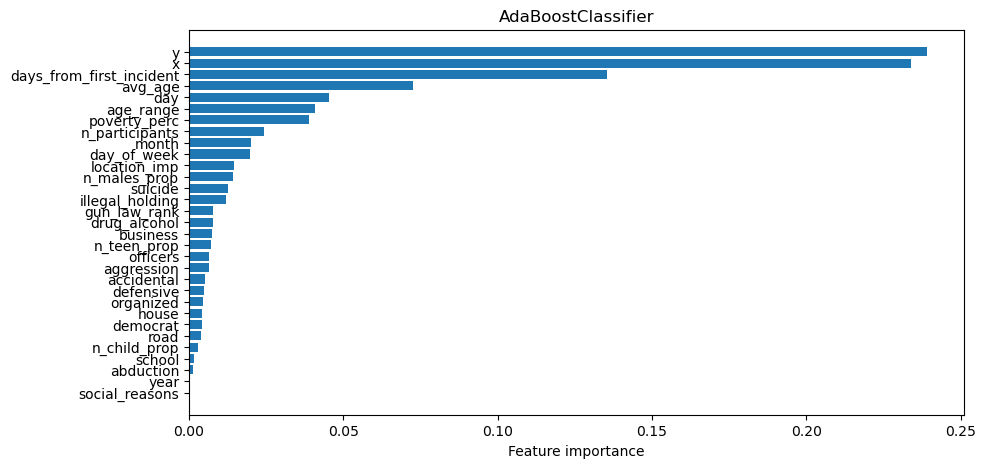

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
display_feature_importances(
    feature_names=best_model.feature_names_in_,
    feature_importances=best_model.feature_importances_,
    axs=axs,
    title=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_feature_importances.csv'
)

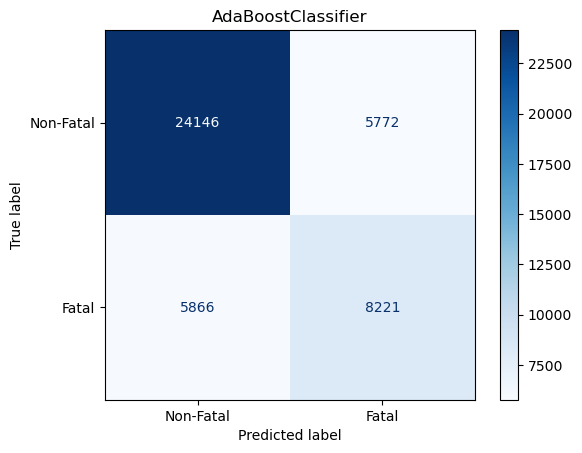

In [19]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    title=clf_name,
)

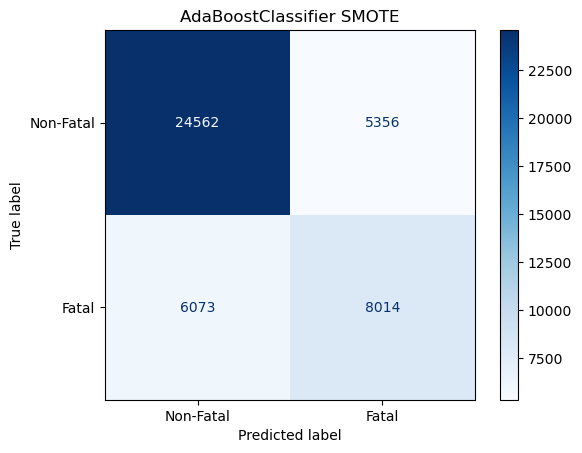

In [20]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    title=clf_name + ' SMOTE'
)

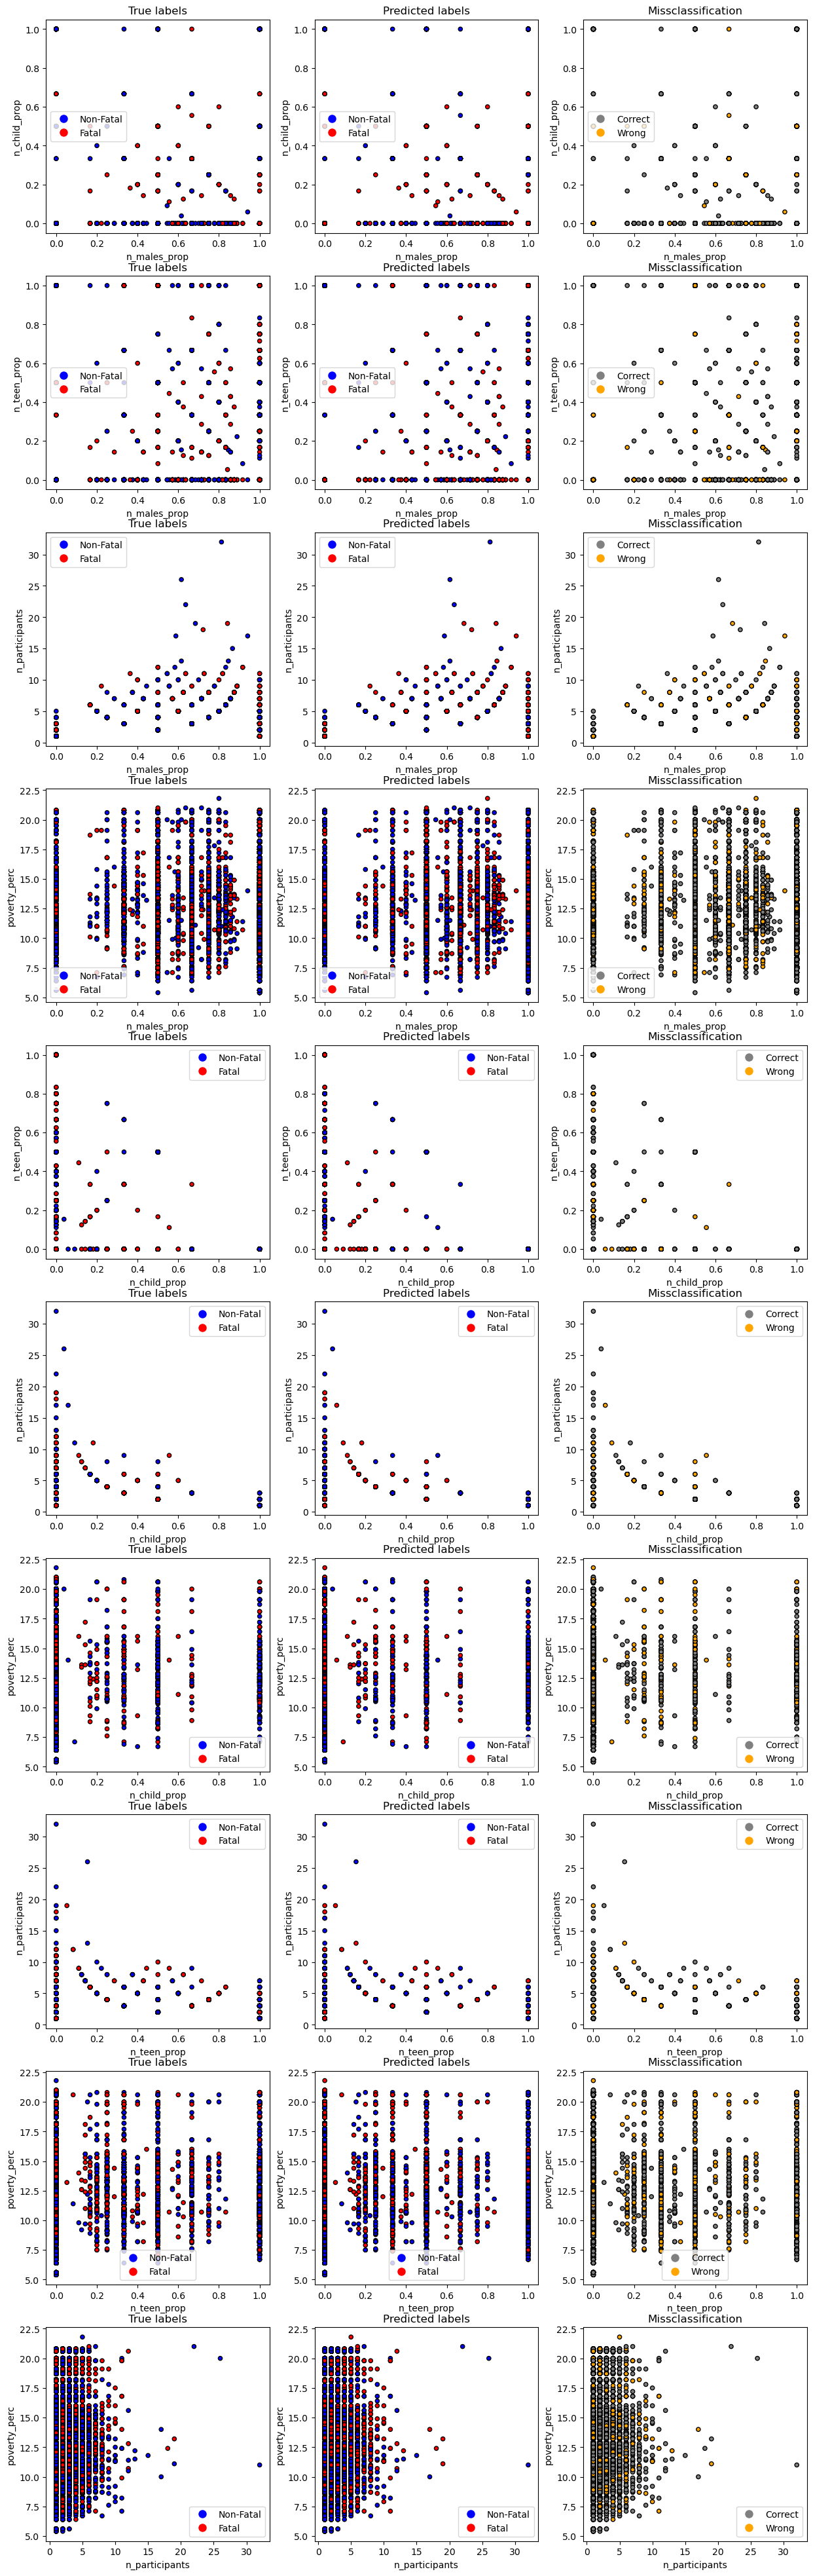

In [21]:
plot_predictions_in_features_space(
    df=incidents_test_df,
    features=['n_males_prop', 'n_child_prop', 'n_teen_prop', 'n_participants', 'poverty_perc'],
    true_labels=true_labels_test,
    pred_labels=pred_labels_test,
    figsize=(15, 50)
)

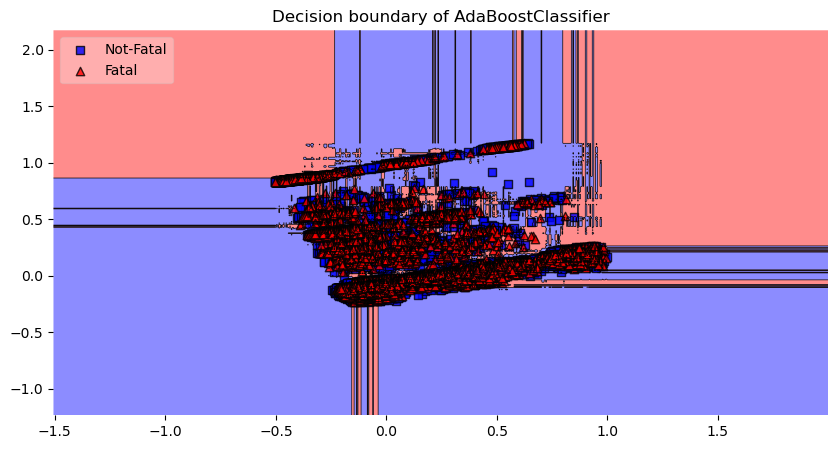

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_PCA_decision_boundary(
  train_set=indicators_train_df,
  features=[col for col in indicators_train_df.columns if col not in categorical_features],
  train_label=true_labels_train,
  classifier=best_model,
  classifier_name=clf_name,
  axs=axs,
  scale=True,
  pca=True
)

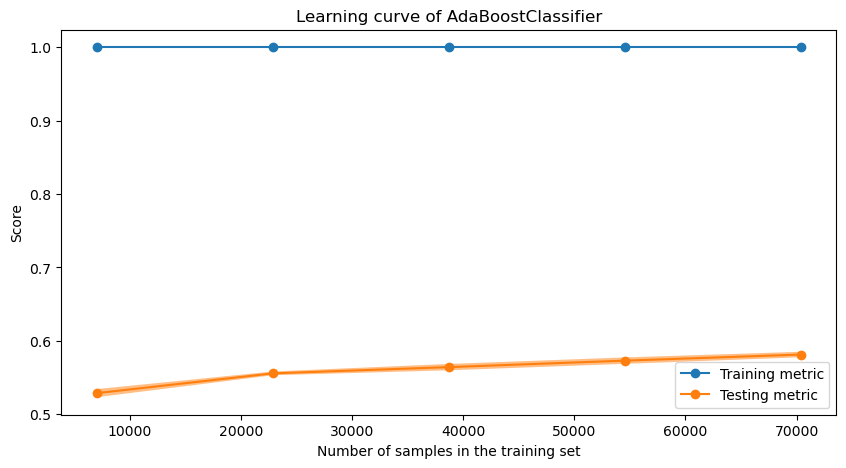

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_learning_curve(
    classifier=best_model,
    classifier_name=clf_name,
    train_set=indicators_train_df,
    labels=true_labels_train,
    ax=axs,
    train_sizes=np.linspace(0.1, 1.0, 5),
    metric='f1'
)

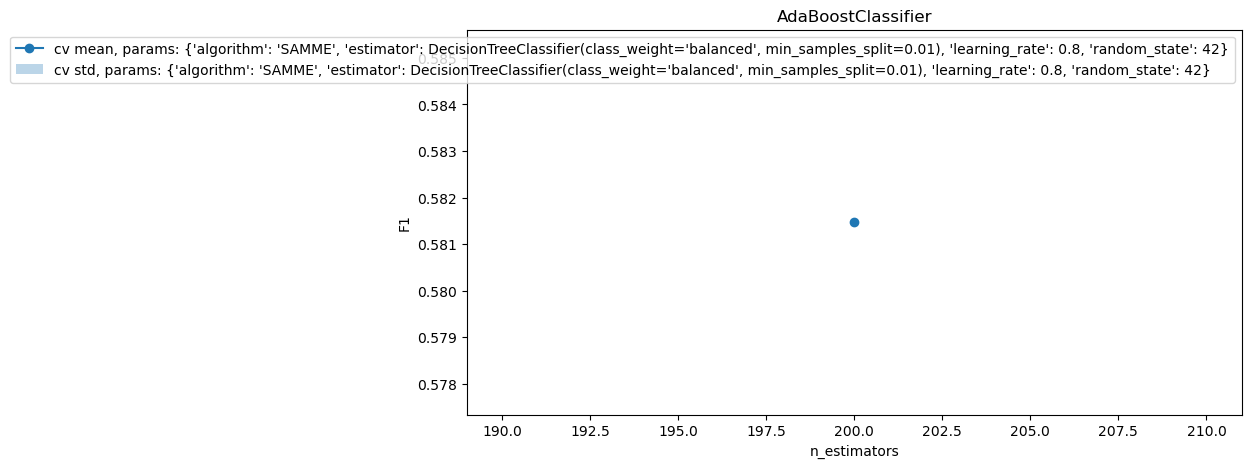

In [25]:
param_of_interest = 'n_estimators'
fixed_params = best_model_params.copy()
fixed_params.pop(param_of_interest)
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_scores_varying_params(
    cv_results_df,
    param_of_interest,
    fixed_params,
    'F1',
    axs,
    title=clf_name
)

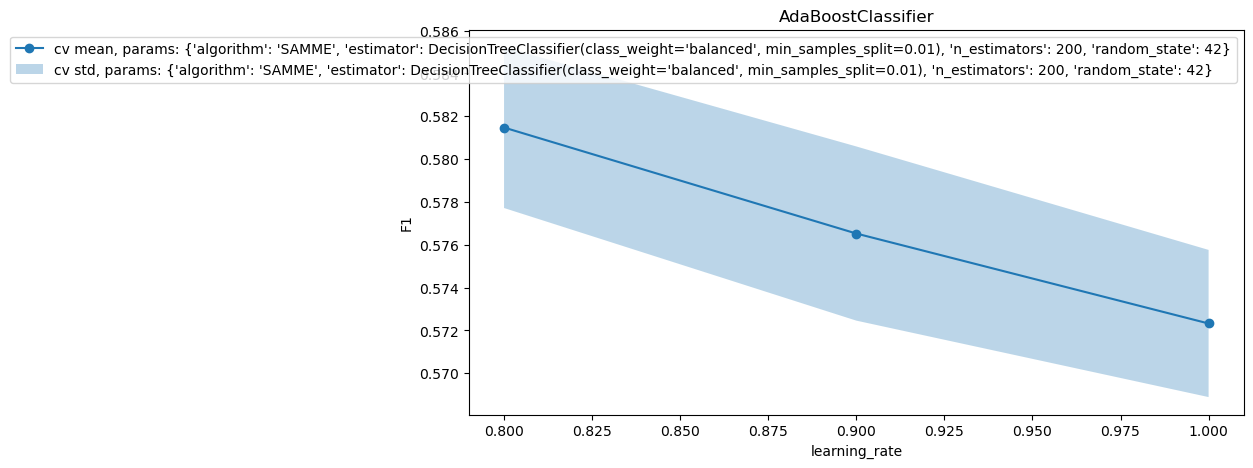

In [26]:
param_of_interest = 'learning_rate'
fixed_params = best_model_params.copy()
fixed_params.pop(param_of_interest)
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_scores_varying_params(
    cv_results_df,
    param_of_interest,
    fixed_params,
    'F1',
    axs,
    title=clf_name
)

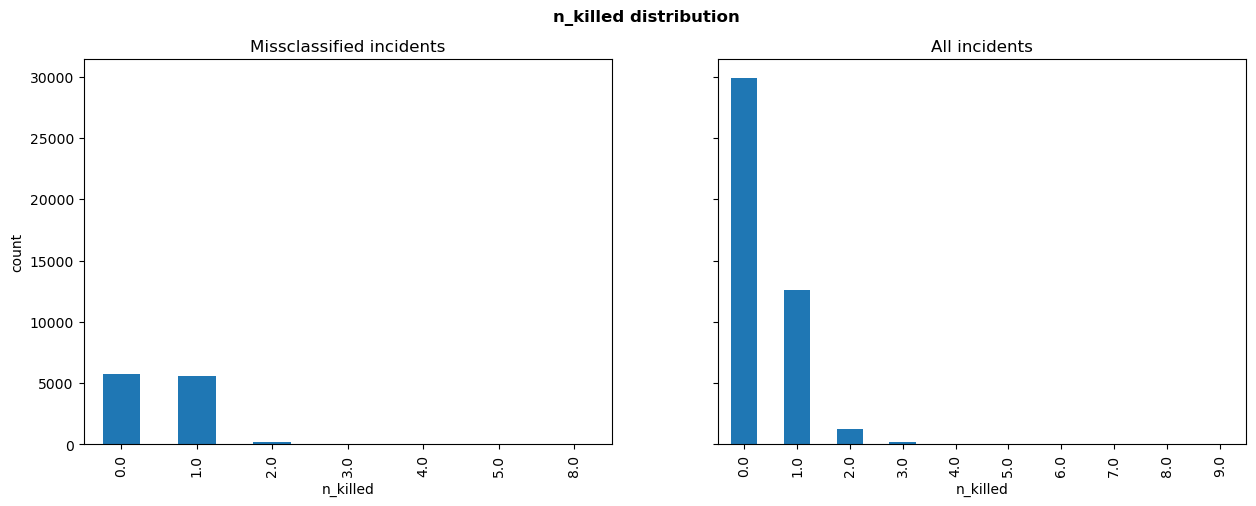

In [27]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'n_killed',
    'bar',
    title='n_killed distribution'
)

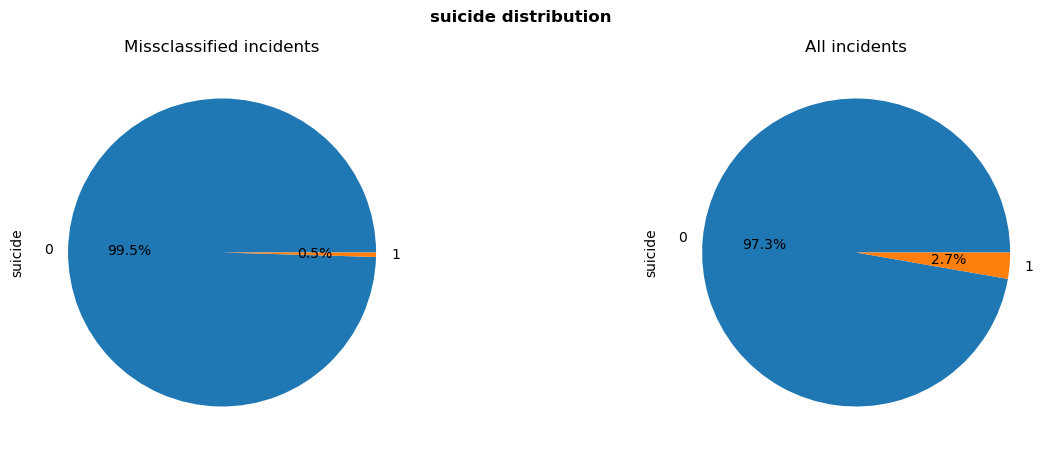

In [28]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'suicide',
    'pie',
    title='suicide distribution'
)

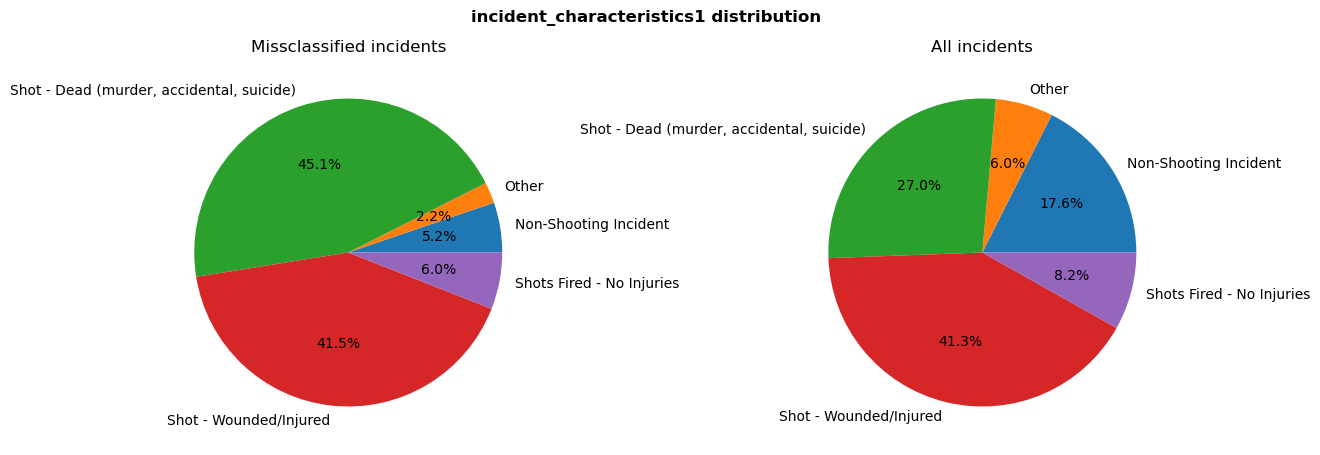

In [29]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics1',
    'pie',
    title='incident_characteristics1 distribution'
)

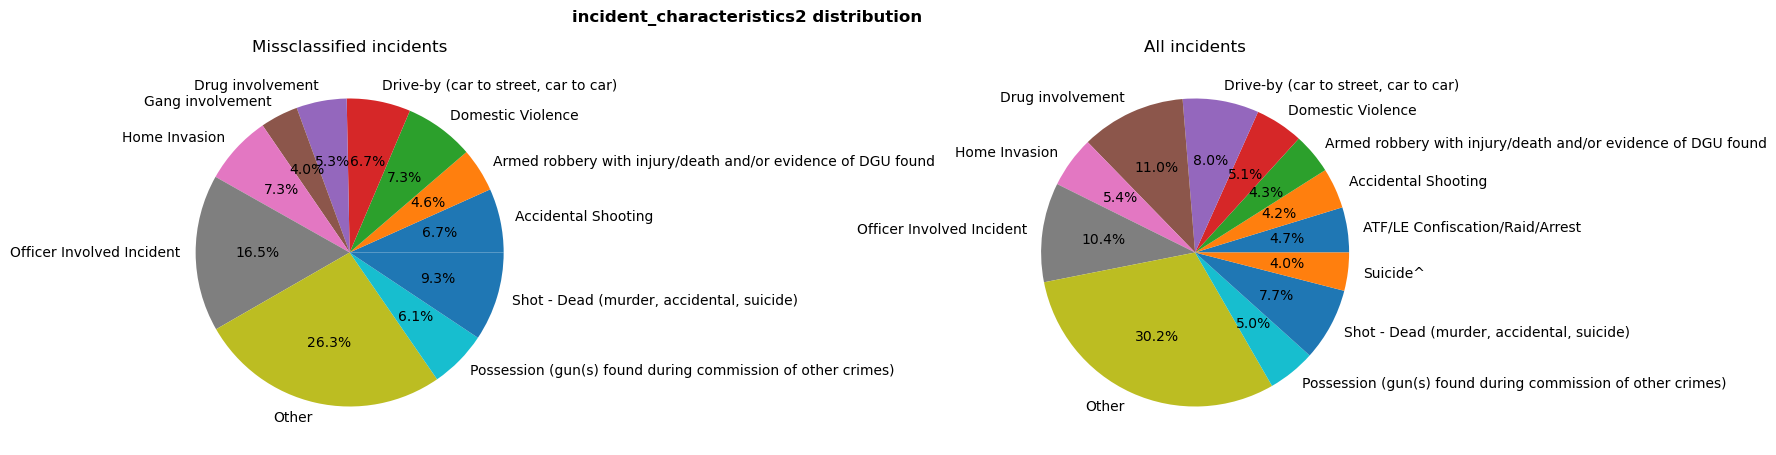

In [30]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics2',
    'pie',
    pie_perc_threshold=2,
    figsize=(20, 5),
    title='incident_characteristics2 distribution'
)

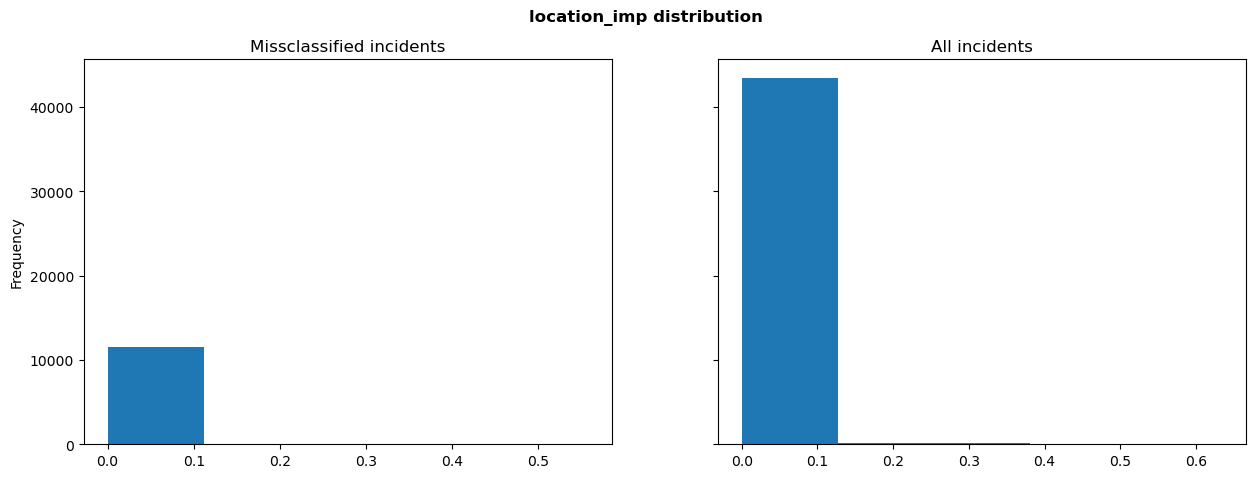

In [31]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'location_imp',
    'hist',
    bins=5,
    title='location_imp distribution'
)